In [42]:
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix, hstack, vstack, diags, eye
import scipy as sp
import scipy.sparse as sps

from typing import Union


In [34]:
import sklearn

In [44]:
clfe = DecisionTreeClassifier(max_depth=4)

# Train the classifier
clfe.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [92]:
tree_2 = Tree(clfe)

In [91]:
class Tree:

    __tree = None
    __adj_matrix = None

    def __init__(self,
                 tree: Union[sklearn.tree._classes.DecisionTreeClassifier,
                             sklearn.tree._classes.DecisionTreeRegressor,
                             sklearn.tree._classes.ExtraTreeClassifier,
                             sklearn.tree._classes.ExtraTreeRegressor],
                 make_adj_matrix: bool = True):

        self.__tree = tree.tree_

        if make_adj_matrix: self.adjacency_matrix()


    def adjacency_matrix(self, sparse=True):
        """
        Create an adjacency matrix in CSR format for the given decision tree.
        """
        tree = self.__tree

        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right

        row_indices = []
        col_indices = []

        for node in range(n_nodes):
            if children_left[node] != children_right[node]:  # Internal node
                row_indices.extend([node, node])
                col_indices.extend([children_left[node], children_right[node]])

        self.__adj_matrix = sps.csr_matrix((np.ones(len(row_indices)), (row_indices, col_indices)),
                                           shape=(n_nodes, n_nodes), dtype=int)
    def get_tree(self) -> sklearn.tree._tree.Tree:
        return self.__tree

    def get_adj_matrix(self, sparse=True) -> sps._csr.csr_matrix:
        if self.__adj_matrix is not None:
            self.adjacency_matrix()
        return self.__adj_matrix if sparse else self.__adj_matrix.toarray()




In [134]:
class Embedding:

    __space_type = None
    __tree = None
    __tree_adj_mat = None
    __alphas = None
    __eigvals = None
    __eigvecs = None

    def __init__(self, tree: Tree, space_type: str = 'Euclidean', alphas: np.ndarray = None):
        self.__tree = tree
        self.__tree_adj_mat = self.__tree.get_adj_matrix()
        self.__space_type = space_type

    def make_eigenmaps(self, embed_dim: int,
                       normed: bool = False,
                       symmetrized: bool = True):

        lap, lap_diag = sps.csgraph.laplacian(self.__tree_adj_mat.astype('float32'),
                                     normed=normed, symmetrized=symmetrized, return_diag=True)

        if self.__space_type == 'Euclidean':
            lap *= -1
            lap += sps.eye(*lap.shape)
            eigvals, eigvecs = sps.linalg.eigsh(lap, k=embed_dim+1, sigma=1.0, which='LM')

            # dropping zero eigenvalue along with constant eigenvector

            eigvals = 1 - eigvals[:-1]
            eigvecs = eigvecs[:, :-1] / lap_diag[:, None]

        elif self.__space_type == 'Hyperbolic':

            """Create a hyperbolic Laplacian matrix for a given adjacency matrix
                and alpha vector.

            If the `alpha_arr` that tracks the connections of our artificial node
            is not given, it is assumed that all alphas are equal, and the vector
            is normalized.

            We symmetrize the g_adj_matrix if the corresponding flag is given
            (and by default).
            Note that this just means adding its conjugate transpose, which
            will corrupt the weights if they are partially symmetrized already
            or double them if they are fully symmetrized.

            :param g_adj_matrix: Sparse adjacency matrix of the graph.
            :param alpha_arr: Vector of alpha values, if present.
            :param symmetrize: Whether to symmetrize the adjacency matrix
            :return: Sparse hyperbolic Laplacian matrix.
            """
            lap = lap.tocsr()

            if self.__alphas is None:
                self.__alphas = np.full(self.__tree_adj_mat.shape[0],
                                        1. / self.__tree_adj_mat.shape[0])

            # Now we make the diagonal equal the standard Laplacian diag
            # minus alpha_arr:
            lap = (lap - sps.diags(self.__alphas, offsets=0, format='csr'))

            top = sps.hstack(
                (sps.csr_matrix([[-np.add.reduce(self.__alphas)]]),
                sps.csr_matrix(self.__alphas)))
            bottom_rows = sps.hstack(
                (sps.csr_matrix(self.__alphas).T,
                lap), format='csr')

            lap = sps.vstack((top, bottom_rows), format='csr')

            eigvals, eigvecs = sps.linalg.eigsh(lap, k=embed_dim+1, which='SM')

            # dropping zero eigenvalue along with constant eigenvector

            eigvals, eigvecs = eigvals[1:], eigvecs[:, 1:]

        else:
            print('Type not supported')
            self.__eigvals = None
            self.__eigvecs = None

        self.__eigvals = eigvals
        self.__eigvecs = eigvecs

    def get_eigenmap(self, embed_dim: int,
                     normed: bool = False,
                     symmetrized: bool = True) -> tuple[np.ndarray]:

        self.make_eigenmaps(embed_dim, normed=normed,
                            symmetrized=symmetrized)

        return self.__eigvals, self.__eigvecs

    def plot_eigen_dependency(self, idx_1, idx_2, title='Graph with Edges'):
        x = self.__eigvecs[:, idx_1]
        y = self.__eigvecs[:, idx_2]

        plt.scatter(x, y)

        # Draw edges
        rows, cols = self.__tree_adj_mat.nonzero()
        for i in range(len(rows)):
            plt.plot([x[rows[i]], x[cols[i]]], [y[rows[i]], y[cols[i]]], 'k-', alpha=0.5)

        plt.xlabel('Eigenvector 1')
        plt.ylabel('Eigenvector 2')
        plt.title(title)
        # plt.savefig(title+'.png')
        plt.show()

In [136]:
embed_2 = Embedding(tree_2, space_type='Hyperbolic')

In [146]:
eigvals, eigvecs = embed_2.get_eigenmap(10)

In [147]:
eigvecs_n = eigvecs * (1 / np.sqrt(eigvals))

##### The hypothesis that projecting binary graphs into a suitable two-dimensional subspace in hyperbolic space results in minimal or no edge crossings has significant theoretical implications:

Geometric Representation of Graphs: This hypothesis explores the geometric representation of binary graphs in hyperbolic space. Due to its unique geometric properties, such as negative curvature, hyperbolic space is apt for representing graphs with high clustering and hierarchical structures. This representation can reveal intrinsic structures and properties of the graph.

Connection Between Topology and Geometry: By projecting into hyperbolic space and analyzing the intersection of edges, a deeper understanding can be gained about the relationship between the graph's topological structure and its geometric representation.

Geometric Optimization: Proving this hypothesis could provide insights into how to effectively represent complex networks in low-dimensional spaces, which is crucial for understanding and optimizing the geometric structure of graphs.

#### Not taking 2 eigenvectors and just plot them, but do the following: to take 3 eigenvectors and create projection on 2d plane in the following way:
vertex i —> (x_i/x_0-y_i/y_0; x_i/x_0-z_i/z_0), so 2 coordinates of each vertex can be calculated using 3 components corresponding to 3 different eigenvectors. Note that zero eigenvector correspond to extension of the standard laplacian.

### For different trees - RandomForest, GradientBoosting and ExtraTrees

In [8]:
%%time
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=42)
rf_clf.fit(X_train, y_train)
# Train a Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=42)
gb_clf.fit(X_train, y_train)
# Train an Extra Trees Classifier
et_clf = ExtraTreesClassifier(n_estimators=10, max_depth=4, random_state=42)
et_clf.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [49]:
type(et_clf)

sklearn.ensemble._forest.ExtraTreesClassifier

In [9]:
single_tree_rf = rf_clf.estimators_[0]

In [ ]:
from sklearn.tree import plot_tree

In [20]:
type(single_tree_rf)

sklearn.tree._classes.DecisionTreeClassifier

30

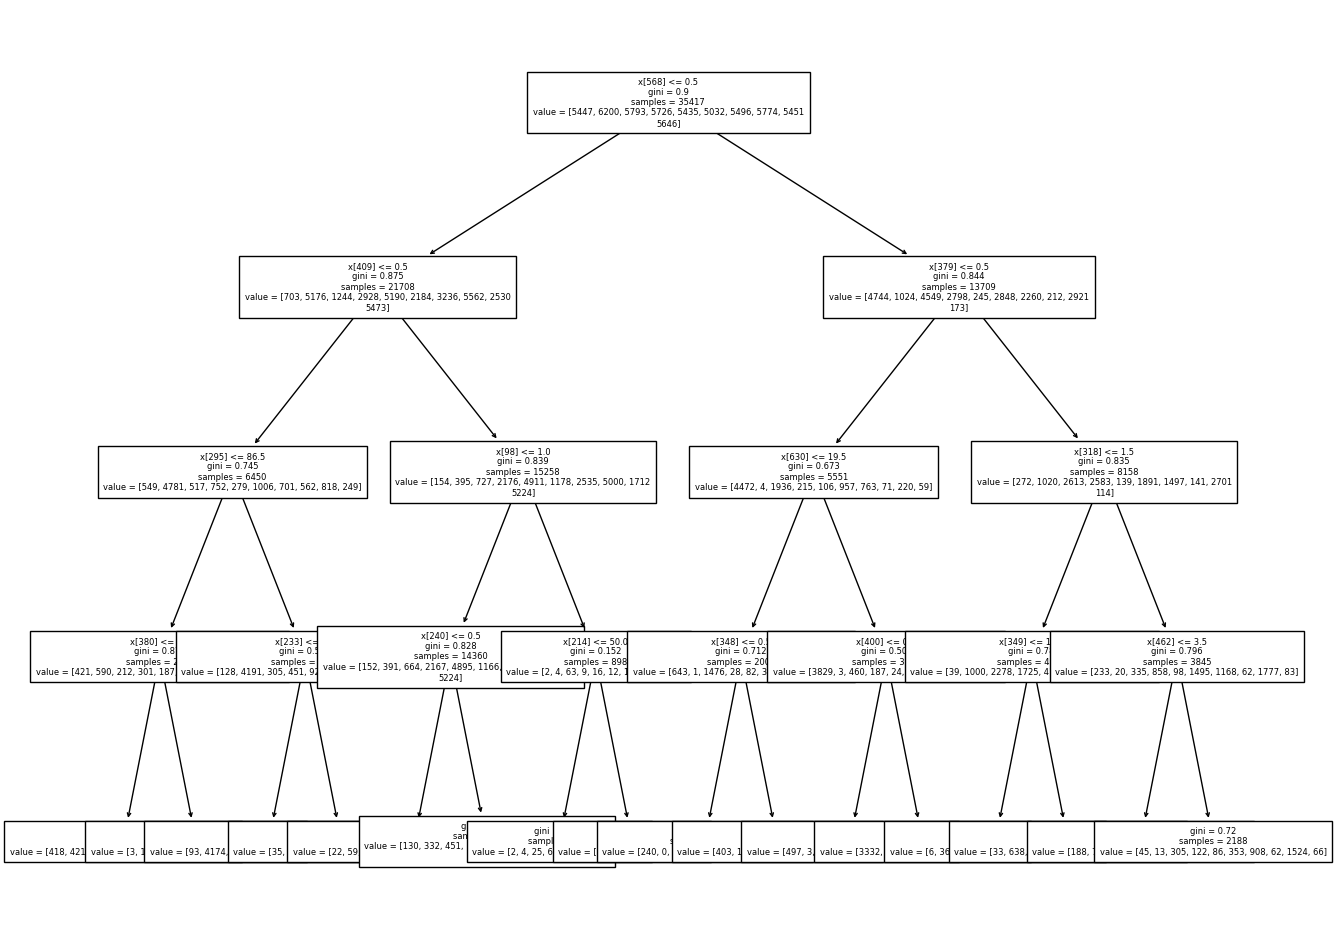

In [30]:
fig = plt.figure(figsize=(15, 12))
plot_tree(single_tree_rf, fontsize=6, max_depth=4)
plt.show()

In [ ]:
# Select a single tree from each ensemble for visualization
# For RandomForest and ExtraTrees
single_tree_rf = rf_clf.estimators_[0]
single_tree_et = et_clf.estimators_[0]
# For GradientBoosting
single_tree_gb = gb_clf.estimators_[0, 0]  # First tree of the first class

adj_matrix_rf = create_adjacency_matrix(single_tree_rf.tree_)
adj_matrix_gb = create_adjacency_matrix(single_tree_gb.tree_)
adj_matrix_et = create_adjacency_matrix(single_tree_et.tree_)

In [ ]:
single_tree_rf.tree_

NameError: ignored

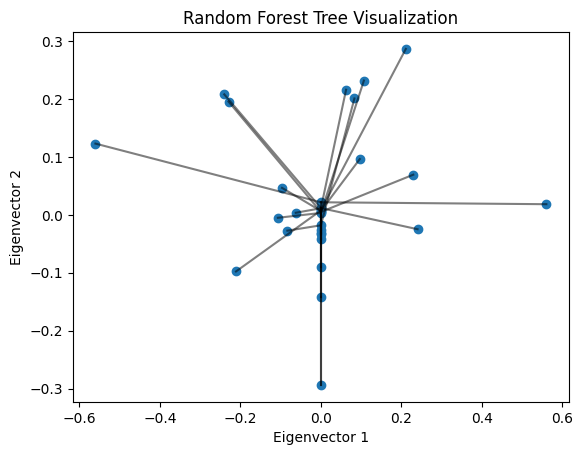

In [ ]:
# For Random Forest tree
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=10)
plot_graph_with_edges(eigvecs_rf[:, 0], eigvecs_rf[:, 1], adj_matrix_rf, title='Random Forest Tree Visualization')

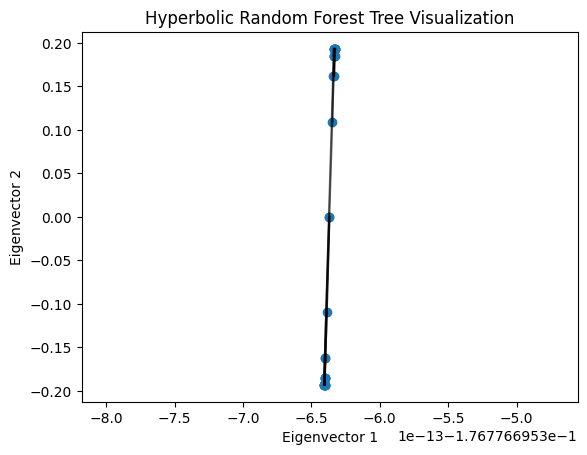

In [ ]:
# For Random Forest tree
n = adj_matrix_rf.shape[0]
heigvals_rf, heigvecs_rf = hyperbolic_laplacian_eigenmaps(adj_matrix_rf, alpha= 1./n * np.ones(n), embed_dim=10)
plot_graph_with_edges(heigvecs_rf[:, 0], heigvecs_rf[:, 1], adj_matrix_rf, title='Hyperbolic Random Forest Tree Visualization')

In [ ]:
len(eigvecs_rf)

31

In [ ]:
len(heigvecs_rf)

32

In [ ]:
print(heigvecs_rf[:,0])

[-0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767
 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767
 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767
 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767
 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767 -0.1767767
 -0.1767767 -0.1767767]


In [ ]:
for i, element in enumerate(heigvecs_rf.T):
    a.append(element * 1/(np.sqrt(heigvals_rf[i])))

In [ ]:
np.linalg.norm(a[1])

11.143213576918114

62788967.05589616

In [ ]:
heigvals_rf

array([2.53649098e-16, 8.05339667e-03, 6.45300096e-02, 6.45300096e-02,
       2.35691128e-01, 2.35691128e-01, 2.35691128e-01, 2.35691128e-01,
       6.79496324e-01, 9.67741935e-01])

In [ ]:
np.linalg.norm(1/np.sqrt(heigvals_rf[8]) * heigvecs_rf[:,8])

1.2131274899839715

For each eigenvector of the laplacian: $v \to |v|_2 = \frac{1}{\sqrt{\lambda}}$

Если взять все одинаковые альфы, то пространство получается такое же как и при обычном лапласиане. Если нет, то получится что-то другое.

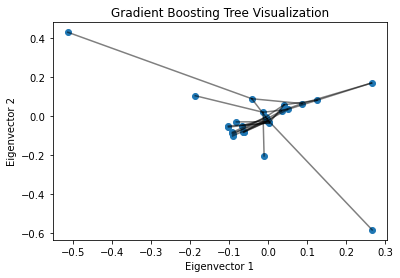

In [ ]:
# For Gradient Boosting tree
eigvals_gb, eigvecs_gb = laplacian_eigenmaps(adj_matrix_gb, embed_dim=10)
plot_graph_with_edges(eigvecs_gb[:, 0], eigvecs_gb[:, 1], adj_matrix_gb, title='Gradient Boosting Tree Visualization')


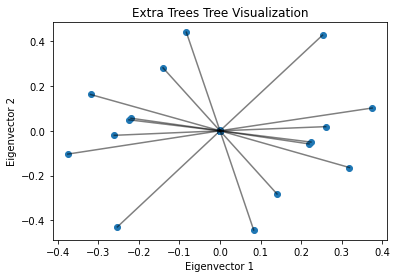

In [ ]:
# For Extra Trees tree
eigvals_et, eigvecs_et = laplacian_eigenmaps(adj_matrix_et, embed_dim=10)
plot_graph_with_edges(eigvecs_et[:, 0], eigvecs_et[:, 1], adj_matrix_et, title='Extra Trees Tree Visualization')

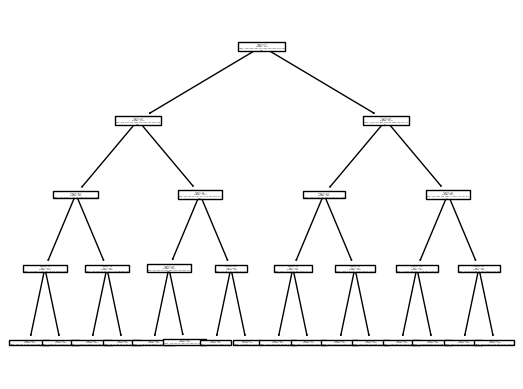

In [ ]:
tree.plot_tree(single_tree_rf)
plt.show()

In [ ]:
# Number of nodes in the tree
print(f"Number of nodes: {single_tree_rf.tree_.node_count}")

# Function to calculate the depth of the decision tree
def tree_depth(tree):
    """
    This function recursively finds the depth of a decision tree.
    """
    def _walk(node_id, current_depth):
        left_child = tree.children_left[node_id]
        right_child = tree.children_right[node_id]
        if left_child == right_child:  # leaf node
            return current_depth
        return max(_walk(left_child, current_depth + 1),
                   _walk(right_child, current_depth + 1))

    root_node_id = 0
    return _walk(root_node_id, 1)

# Calculate and print the depth of the tree
depth = tree_depth(single_tree_rf.tree_)
print(f"Depth of the tree: {depth}")

Number of nodes: 31
Depth of the tree: 5


In [ ]:
def project_vertices(eigvecs):
    """
    Project vertices onto a 2D plane using components from three eigenvectors.

    The function uses a projection formula where each vertex `i` is mapped to a 2D point.
    The coordinates for each vertex are computed using components of three different eigenvectors
    (x, y, z) obtained from the hyperbolic Laplacian. The projection formula is as follows:

    x-coordinate: (x_i/x_0) - (y_i/y_0)
    y-coordinate: (x_i/x_0) - (z_i/z_0)

    where x_i, y_i, z_i are the components of the eigenvectors for vertex `i`,
    and x_0, y_0, z_0 are the components of the eigenvectors for the "zeroth" vertex,
    an additional component in the hyperbolic Laplacian.

    Parameters:
    eigvecs (numpy.ndarray): An array of eigenvectors obtained from the hyperbolic Laplacian.

    Returns:
    tuple: Two numpy arrays representing the projected x and y coordinates of the vertices.
    """
    x, y, z = eigvecs[:, 0], eigvecs[:, 1], eigvecs[:, 2]
    x0, y0, z0 = x[0], y[0], z[0]

    projected_x = x / x0 - y / y0
    projected_y = x / x0 - z / z0

    return projected_x, projected_y

In [ ]:
def plot_projected_graph(projected_x, projected_y, adjacency_matrix, title='Projected Graph with 3 eigenvectors'):
    plt.scatter(projected_x, projected_y)
    rows, cols = adjacency_matrix.nonzero()
    for i in range(len(rows)):
        plt.plot([projected_x[rows[i]], projected_x[cols[i]]], [projected_y[rows[i]], projected_y[cols[i]]], 'k-', alpha=0.5)

    plt.xlabel('Projected X')
    plt.ylabel('Projected Y')
    plt.title(title)
    plt.show()


<AxesSubplot:>

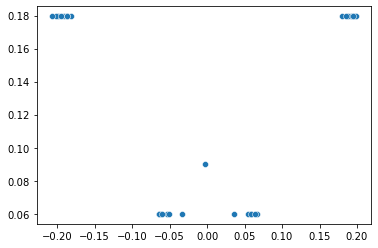

In [ ]:
sns.scatterplot(x=eigvecs_rf[:, -2], y=eigvecs_rf[:, -1])

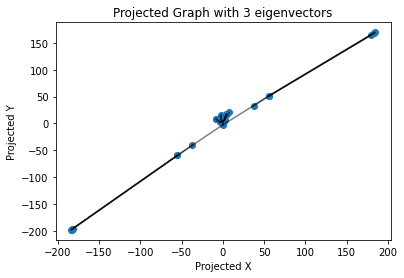

In [ ]:
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_rf)

plot_projected_graph(projected_x, projected_y, adj_matrix_rf)

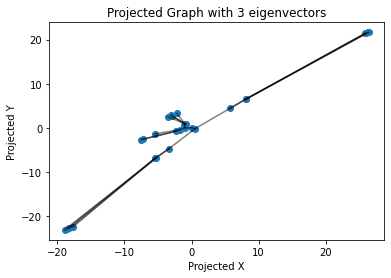

In [ ]:
eigvals_gb, eigvecs_gb = laplacian_eigenmaps(adj_matrix_gb, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_gb)

plot_projected_graph(projected_x, projected_y, adj_matrix_gb)

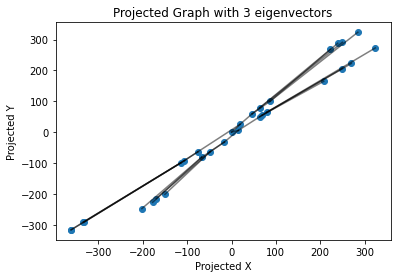

In [ ]:
eigvals_et, eigvecs_et = laplacian_eigenmaps(adj_matrix_et, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_et)

plot_projected_graph(projected_x, projected_y, adj_matrix_et)

In [ ]:
def ccw(A, B, C):
    return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

def check_edge_crossing(p1, p2, q1, q2):
    return ccw(p1, q1, q2) != ccw(p2, q1, q2) and ccw(p1, p2, q1) != ccw(p1, p2, q2)

def plot_projected_graph(projected_x, projected_y, adjacency_matrix, title='Projected Graph with 3 eigenvectors'):
    plt.scatter(projected_x, projected_y)

    # Get all edges from the adjacency matrix
    rows, cols = adjacency_matrix.nonzero()
    edges = list(zip(rows, cols))

    # Check for cycles and plot edges
    for i, (row, col) in enumerate(edges):
        edge_color = 'k-'  # Default color for edges
        for j in range(i + 1, len(edges)):  # Check for crossing with subsequent edges
            other_row, other_col = edges[j]
            if check_edge_crossing((projected_x[row], projected_y[row]), (projected_x[col], projected_y[col]),
                                   (projected_x[other_row], projected_y[other_row]), (projected_x[other_col], projected_y[other_col])):
                edge_color = 'r-'  # Change color to red if there is a crossing
                break  # Stop checking if we found a crossing
        plt.plot([projected_x[row], projected_x[col]], [projected_y[row], projected_y[col]], edge_color, alpha=0.5)

    plt.xlabel('Projected X')
    plt.ylabel('Projected Y')
    plt.title(title)
    plt.show()

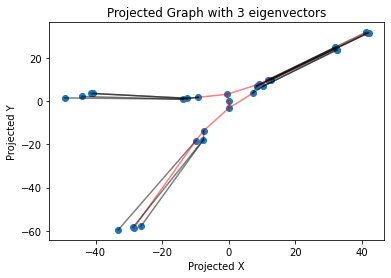

In [ ]:
eigvals_rf, eigvecs_rf = laplacian_eigenmaps(adj_matrix_rf, embed_dim=3)
projected_x, projected_y = project_vertices(eigvecs_rf)

plot_projected_graph(projected_x, projected_y, adj_matrix_rf)

In hyperbolic geometry, lines can diverge more quickly than in Euclidean space due to the negative curvature. When projecting a graph into 2D hyperbolic space, one might expect fewer intersections between edges because of this divergence. However, intersections can still occur, particularly in areas of the graph where the structure is dense or complex.